In [1]:
RUN = 7

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>Note:</b> the raw code for this notebook is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# Setup

In [3]:
import torch
import Darwin as dw
import seaborn as sns

from torchvision import datasets, transforms
from bogus import atk
from ipywidgets  import interactive, fixed
from bokeh.io import output_notebook

output_notebook()
sns.set()

Loading BokehJS ...

In [4]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    telegram_credentials = file.read().split('\n')

In [5]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [6]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.15},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.15}
}

In [7]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.15},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.15}
}

In [8]:
atk_func = atk()

# Run 

In [9]:
testing = dw.TournamentOptimizer(30, LAYER_SPACE, NET_SPACE, dw.randomize_network, 
                           dw.mutate_net, dw.NetFromBuildInfo, dw.train, dw.test,
                          train_loader, test_loader, atk_func.fgsm, telegram_credentials, RUN=RUN)

In [10]:
testing.step(generations=50, epochs=4, save=True, phone=True)

Directory created:  D:\Models\NeuroEvolution/Run7
Generation 1 Population mean:471.46666666666664 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 2 Population mean:821.8666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 3 Population mean:843.2 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 4 Population mean:945.9 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 5 Population mean:861.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 6 Population mean:910.8333333333334 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 7 Population mean:842.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 8 Population mean:923.1333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 9 Population mean:738.8 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 10 Population mean:810.1666666666666 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 11 Population mean:887.8 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 12 Population mean:807.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 13 Population mean:904.4333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 14 Population mean:848.7666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 15 Population mean:823.3333333333334 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 16 Population mean:889.3333333333334 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 17 Population mean:746.5666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 18 Population mean:862.0666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 19 Population mean:930.7333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 20 Population mean:897.5333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 21 Population mean:642.9333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 22 Population mean:793.5 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 23 Population mean:643.1666666666666 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 24 Population mean:588.2333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 25 Population mean:763.2666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 26 Population mean:945.2 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 27 Population mean:976.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 28 Population mean:817.7666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 29 Population mean:800.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 30 Population mean:509.96666666666664 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 31 Population mean:685.9 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 32 Population mean:571.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 33 Population mean:773.3 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 34 Population mean:754.5666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 35 Population mean:734.4333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 36 Population mean:684.5666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 37 Population mean:860.9333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 38 Population mean:594.4333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 39 Population mean:745.3333333333334 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 40 Population mean:834.7 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 41 Population mean:903.6 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 42 Population mean:810.8 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 43 Population mean:785.1666666666666 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 44 Population mean:550.1333333333333 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 45 Population mean:692.1 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 46 Population mean:698.7 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 47 Population mean:754.7 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 48 Population mean:995.5 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 49 Population mean:960.9666666666667 max:1135

Top performers:
0: score:1135
1: score:1135


Generation 50 Population mean:945.4 max:1135

Top performers:
0: score:1135
1: score:1135



# Plots

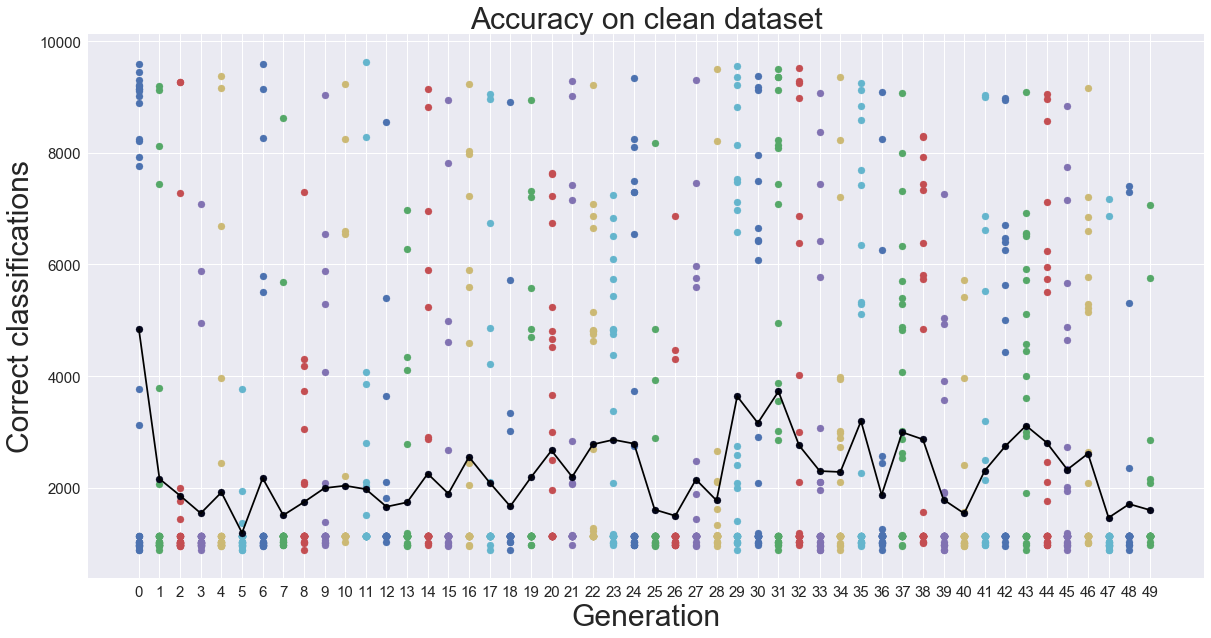

In [11]:
dw.progressplotter(testing, clean=True)

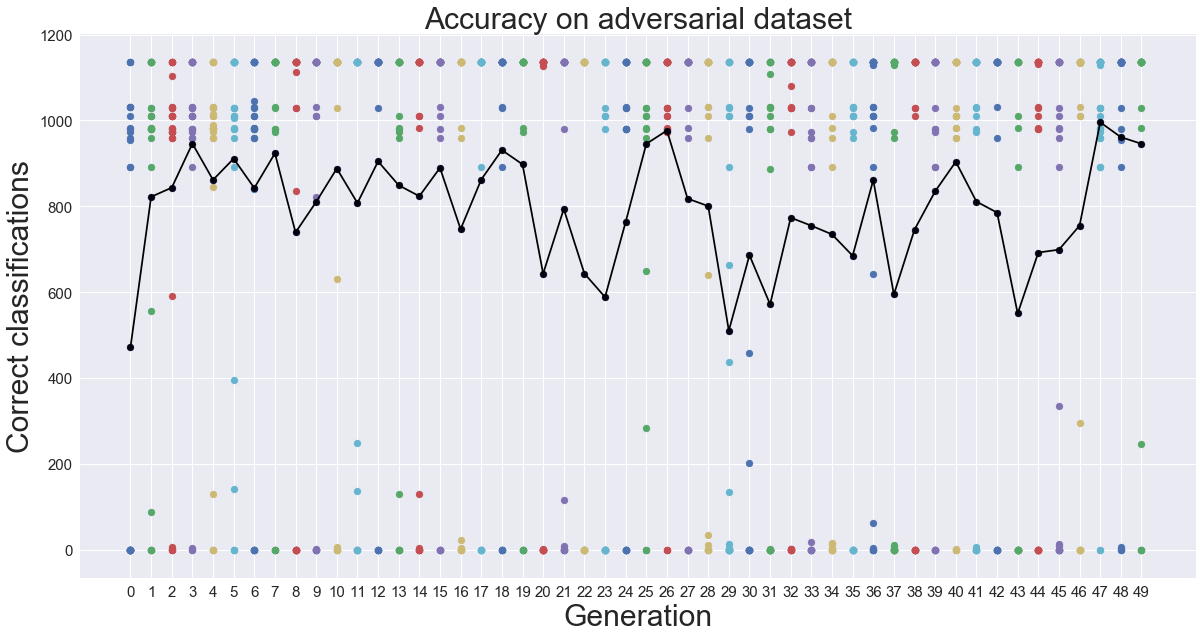

In [12]:
dw.progressplotter(testing)

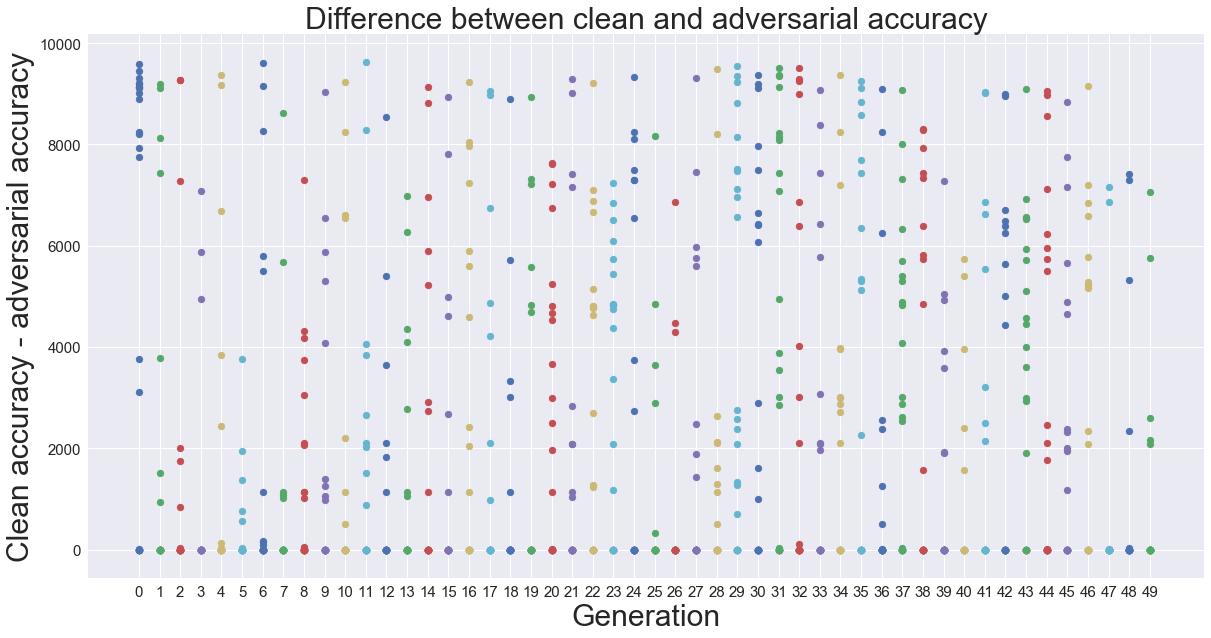

In [13]:
dw.diffplotter(testing)

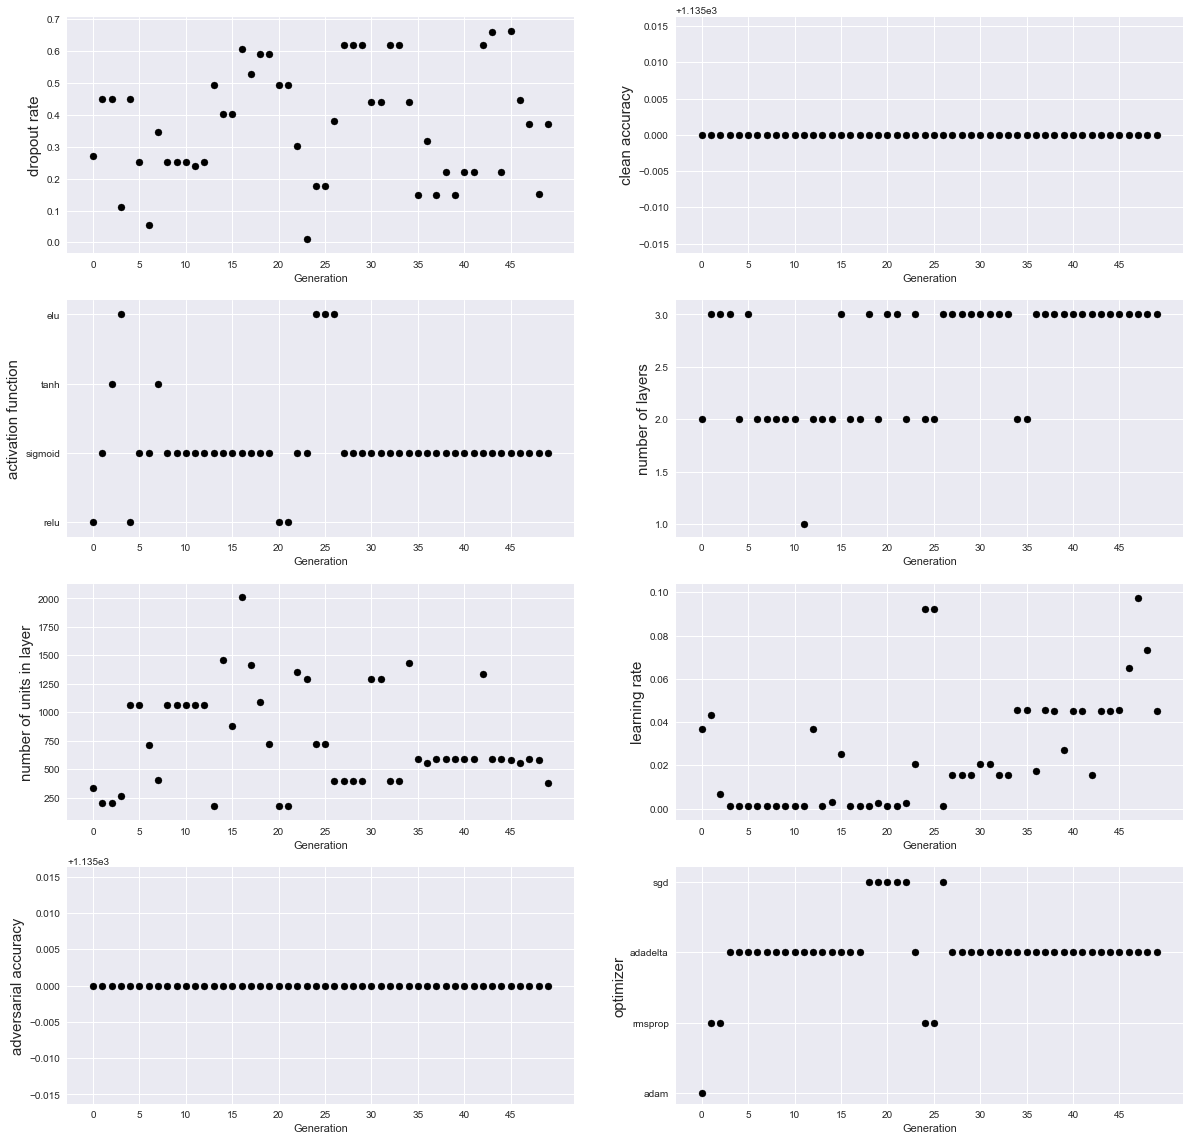

In [14]:
dw.bestplotter(testing, k=0)

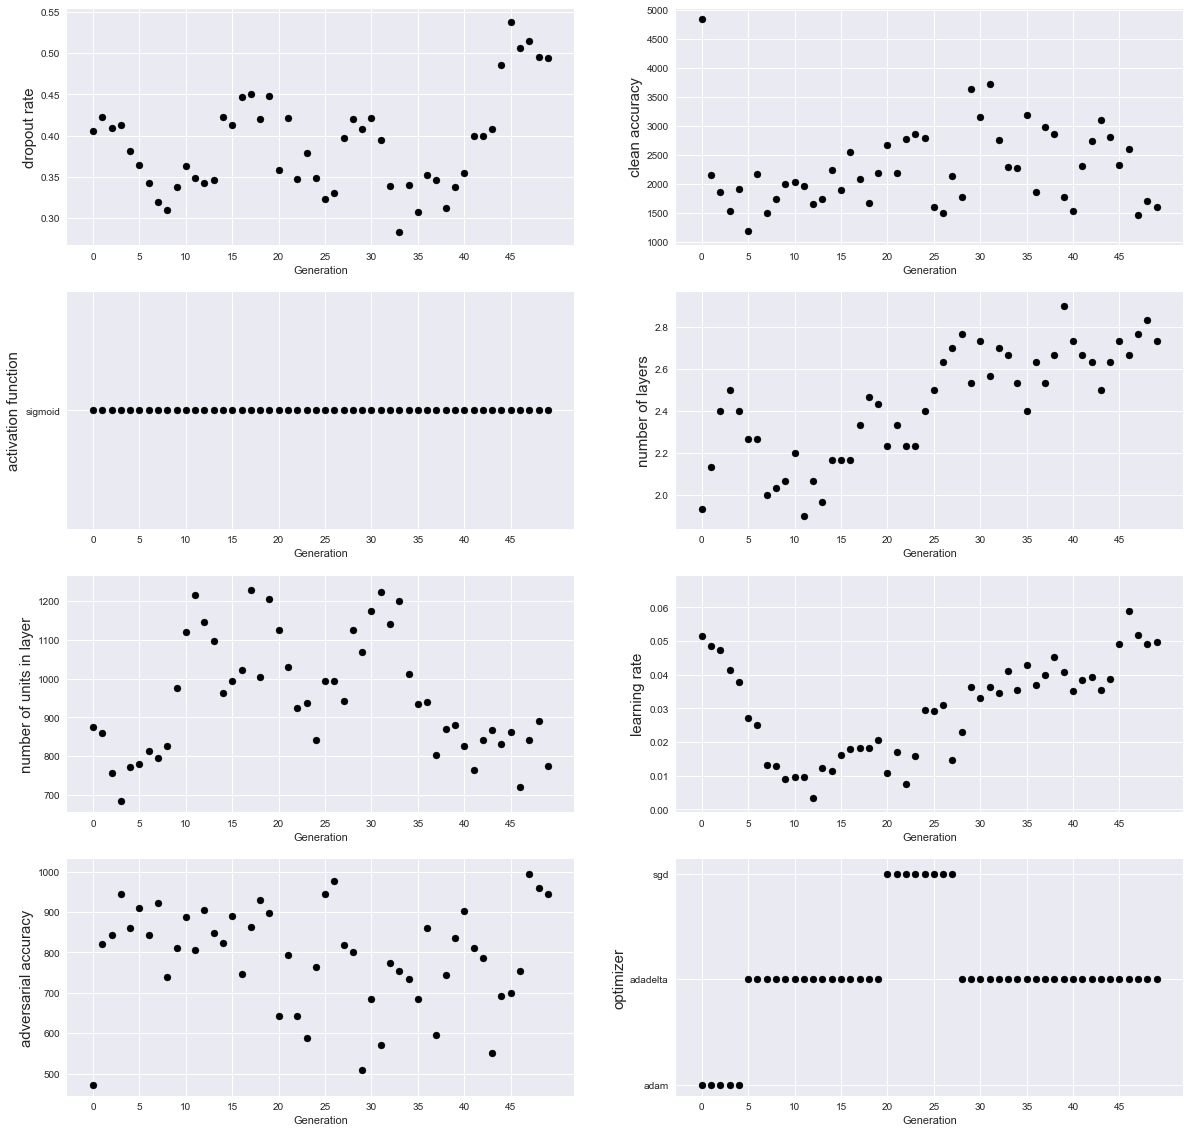

In [15]:
dw.avgplotter(testing)

In [16]:
dw.best_printer(testing, RUN)

,adversarial,clean,generation
best_adversarial,1135,1135,1
best_clean,0,9618,12


Showing best model which was found in generation 1
Clean accuracy = 1135
adversarial accuracy =1135

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1770, bias=True)
    (dropout_0): Dropout(p=0.3148970051726831)
    (sigmoid0): Sigmoid()
    (logits): Linear(in_features=1770, out_features=10, bias=True)
  )
) 

 Images below are adversarial
[[1.26333834e-08 9.99999793e-01 3.28804200e-08 6.55922132e-10
  3.20202145e-08 3.21380256e-08 3.27448424e-08 3.20782309e-08
  3.19082982e-08 7.55433289e-13]]
[[1.45790670e-05 9.99836293e-01 2.51868769e-05 6.90594064e-07
  2.45467305e-05 2.46074223e-05 2.49914878e-05 2.45733583e-05
  2.44974520e-05 3.43246800e-08]]
[[2.05956617e-08 9.99999677e-01 5.11189161e-08 9.44158530e-10
  4.97831893e-08 4.99604851e-08 5.09034268e-08 4.98697197e-08
  4.96174961e-08 1.63807948e-12]]
[[1.05902392e-07 9.99998541e-01 2.30626530e-07 1.73643542e-09
  2.22936688e-07 2.23696741e-07 2.28259469e

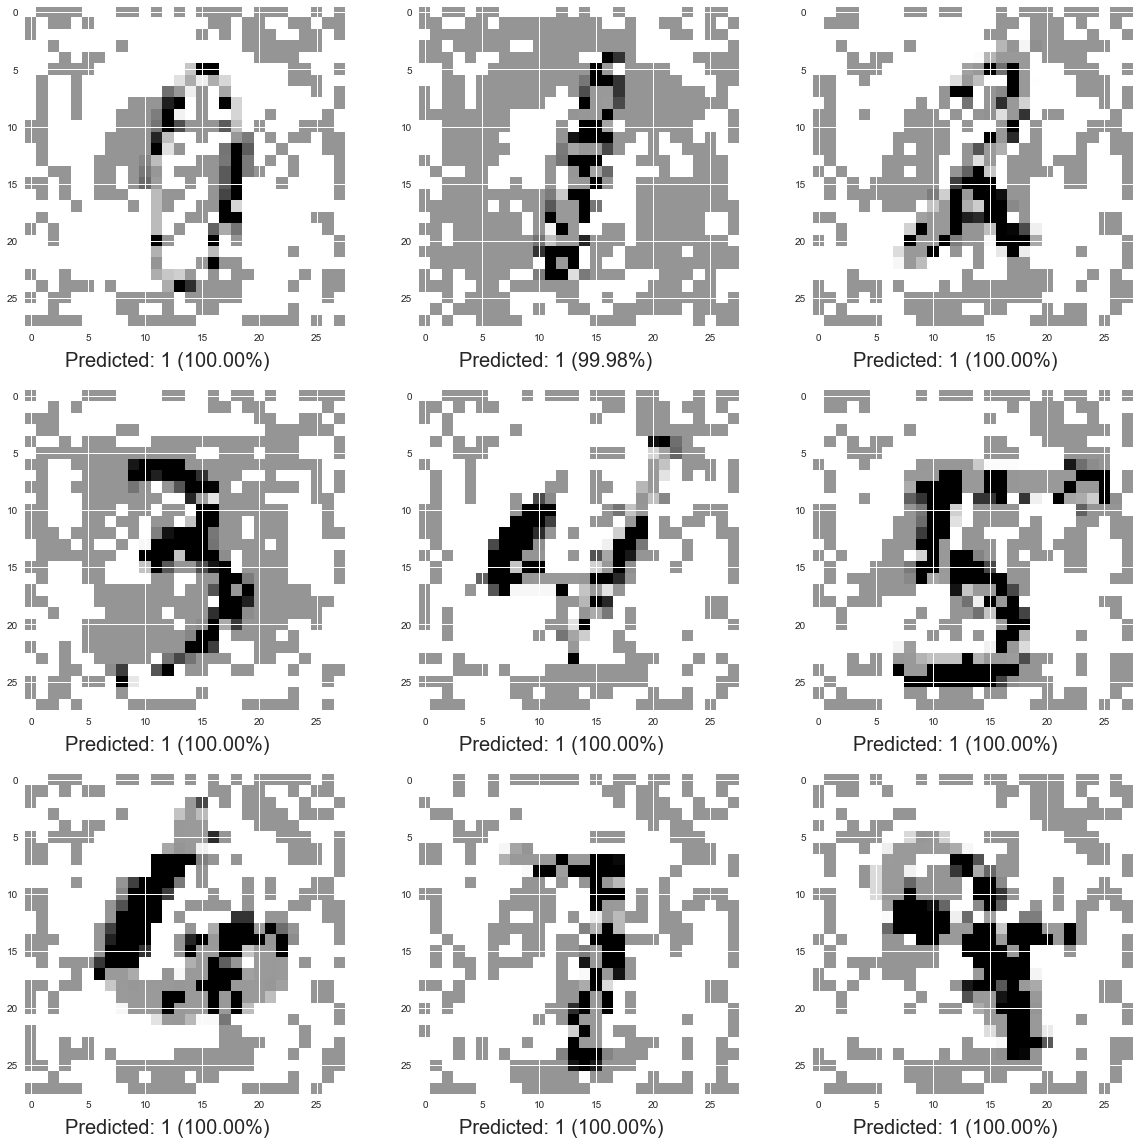

In [17]:
dw.multi_plot(testing, test_loader, RUN, adv_func=atk_func.fgsm, adversarial=True, eps=0.5)

Showing best model which was found in generation 1
Clean accuracy = 1135
adversarial accuracy =1135

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1770, bias=True)
    (dropout_0): Dropout(p=0.3148970051726831)
    (sigmoid0): Sigmoid()
    (logits): Linear(in_features=1770, out_features=10, bias=True)
  )
) 

 Images below are clean
[[3.08228360e-07 9.99995774e-01 6.64328753e-07 9.64884040e-09
  6.45565880e-07 6.47644172e-07 6.60273042e-07 6.46532139e-07
  6.43764954e-07 1.06899475e-10]]
[[5.60697565e-08 9.99999165e-01 1.31800547e-07 3.03839474e-09
  1.28262058e-07 1.28702583e-07 1.31024060e-07 1.28472296e-07
  1.27864657e-07 5.12430567e-12]]
[[1.33782746e-07 9.99998091e-01 3.00938843e-07 5.25130051e-09
  2.92445349e-07 2.93431848e-07 2.98829915e-07 2.92907338e-07
  2.91582466e-07 2.39083464e-11]]
[[2.77501507e-07 9.99996185e-01 6.00924742e-07 7.52824843e-09
  5.82809958e-07 5.84744804e-07 5.96120218e-07 5.

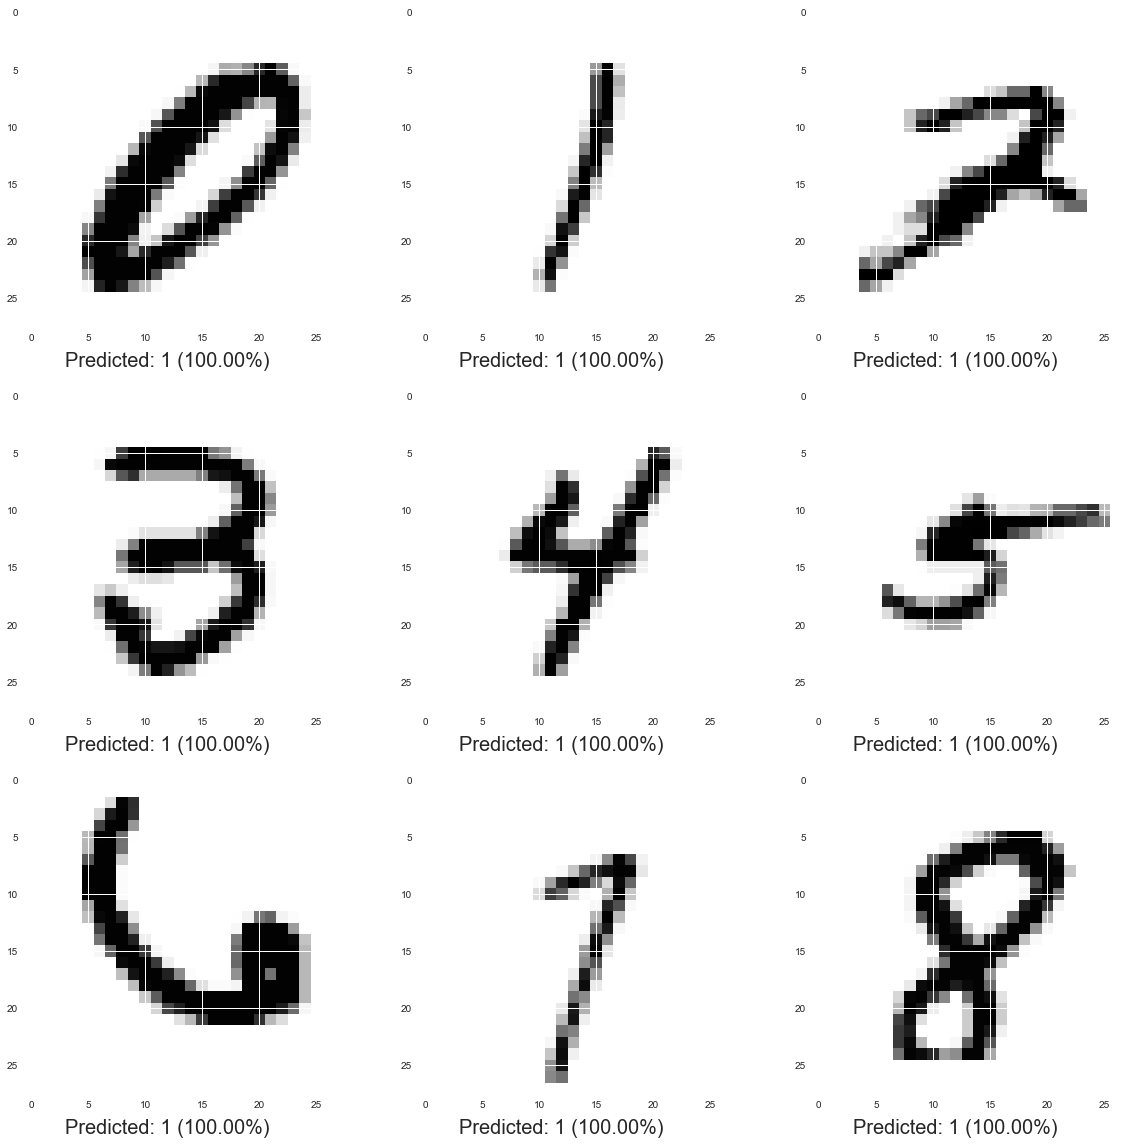

In [18]:
dw.multi_plot(testing, test_loader, RUN, adversarial=False)

In [19]:
df = dw.dataframer(testing)
df.to_pickle(r"../data/neuroevolution{}".format(RUN))

In [20]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(dw.int_plot, df=fixed(df), x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [21]:
interactive_plot #bokeh does not show on Github due to JS restrictions

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…

# Debugging

In [22]:
model = dw.rebuild_from_save(0,generation=38,position=4,run=1, oldrun=True)

{'weight_decay': 0.0002442487687208515, 'lr': 0.05184926115229526, 'nb_layers': 1, 'layers': [{'activation': 'linear', 'dropout_rate': 0.5920481211841264, 'nb_units': 1331}], 'optimizer': 'adadelta'}


In [23]:
dw.test(model, test_loader)

(0.001753286861699102, 8491)

In [24]:
dw.test(model, test_loader, adversarial=True, adv_func=atk_func.fgsm, eps=0.1)

(0.002125334507553641, 3535)

[[0.01423821 0.00257432 0.06072151 0.05699774 0.01073144 0.02162167
  0.0041185  0.00853781 0.77686268 0.04359612]]
[[8.48001689e-02 5.73840726e-04 2.79300724e-02 5.54007438e-02
  1.70369985e-02 9.57807381e-02 3.03574312e-02 8.60927539e-03
  6.50094538e-01 2.94161929e-02]]
[[0.012273   0.2483845  0.00538024 0.06578541 0.04895831 0.03667878
  0.04622528 0.01165133 0.42219426 0.10246888]]
[[0.14754062 0.01341364 0.01266446 0.00150018 0.07750587 0.01536952
  0.31171048 0.00320439 0.38474532 0.03234552]]
[[5.09345806e-02 6.86942722e-05 7.56160030e-02 4.79228955e-03
  4.55205173e-04 3.72136771e-03 5.29184386e-03 4.28425965e-03
  8.50383202e-01 4.45255431e-03]]
[[0.03811647 0.01850081 0.17106745 0.22948912 0.02145091 0.00224766
  0.20103809 0.00272435 0.23747038 0.07789475]]
[[0.02861921 0.0043133  0.03234148 0.40433383 0.00188268 0.04910042
  0.00177451 0.00527444 0.41468789 0.05767223]]
[[0.0153278  0.01290428 0.21983867 0.05262478 0.03231608 0.06362441
  0.10954704 0.00093868 0.47853434 0

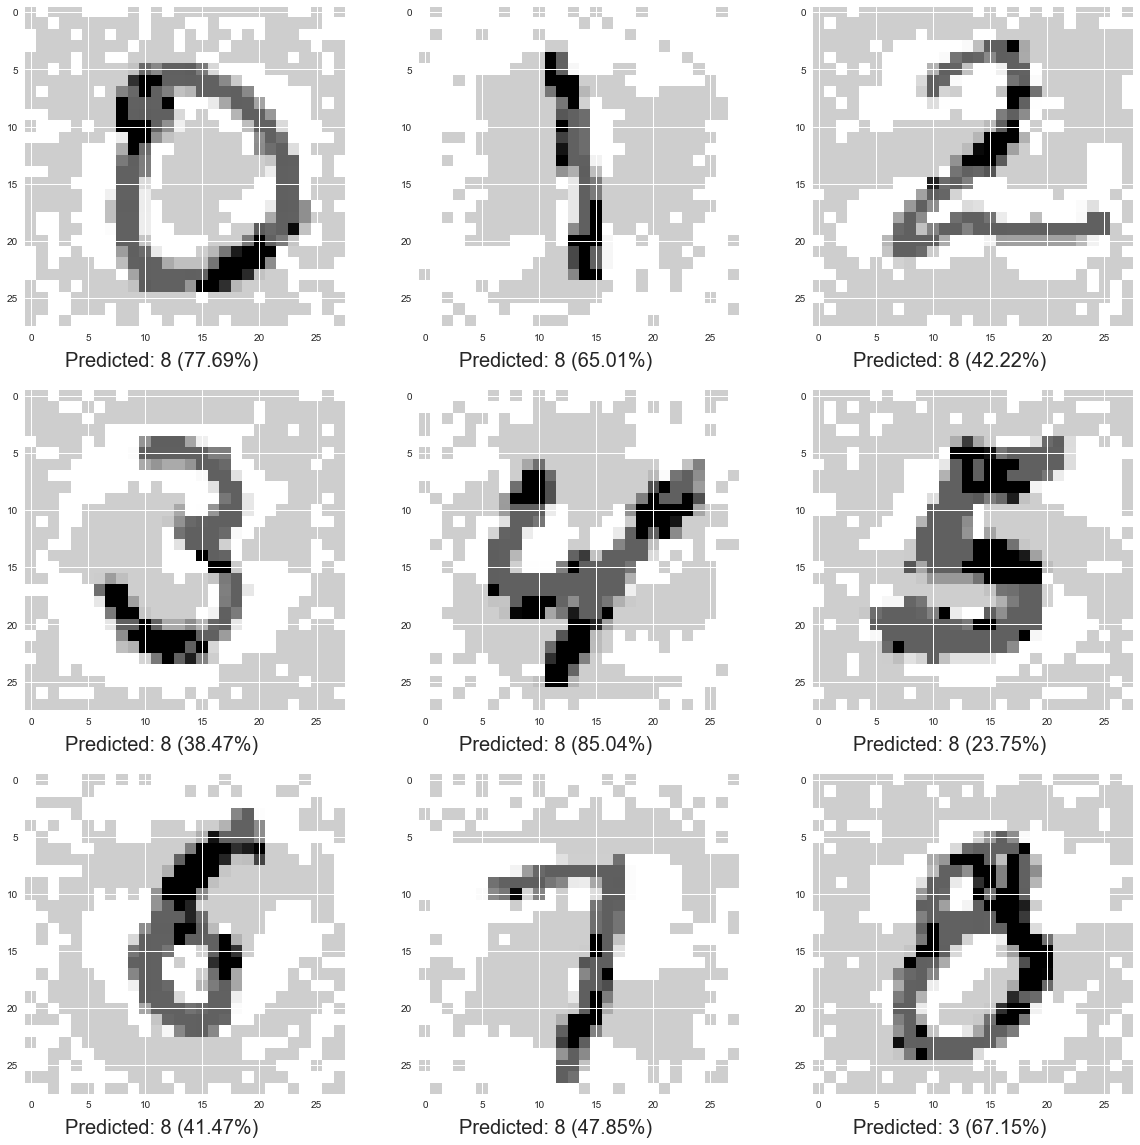

In [25]:
dw.multi_plot(testing, test_loader, RUN, adv_func=atk_func.fgsm, adversarial=True, eps=0.3, model=model)

In [26]:
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [27]:
model = dw.rebuild_from_save(0,generation=38,position=4,run=3, oldrun=True)

{'weight_decay': 0.00025416518171809277, 'layers': [{'nb_units': 1167, 'activation': 'elu', 'dropout_rate': 0.003776959867906404}], 'nb_layers': 1, 'optimizer': 'rmsprop', 'lr': 0.038794508557786225}


In [28]:
model

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1167, bias=True)
    (dropout_0): Dropout(p=0.003776959867906404)
    (elu0): ELU(alpha=1.0)
    (logits): Linear(in_features=1167, out_features=10, bias=True)
  )
)

In [29]:
dw.test(model, test_loader)

(0.001573817453222722, 8869)

In [30]:
batch = next(iter(test_loader))
img = batch[0][0].data
label = batch[1][0]

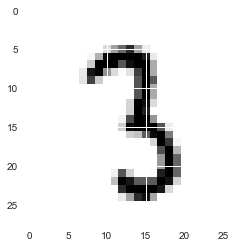

In [31]:
plt.imshow(img.numpy().reshape(28,28), cmap='Greys')

In [32]:
label

tensor(3)

clean softmax =  tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]], dtype=torch.float64, device='cuda:0') 3 1.0 

clean logits =  tensor([[-234.3376,  -35.0729,   93.6634,  605.9822, -221.5047,  -48.1407,
         -492.0722,  -20.0214, -164.6825,  -26.6568]], dtype=torch.float64, device='cuda:0') 3 605.9822219713448 

gradients = none-zero 

logits = tensor([[-1160.9108,   538.3519,  1987.9669,  1593.3032, -1102.4405,
          -693.8991,  -953.0330,  1145.6201,  -981.2373, -1033.2494]], dtype=torch.float64, device='cuda:0') 2 1987.9669157417316 

softmax = tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000]], dtype=torch.float64, device='cuda:0') 2 1.0 



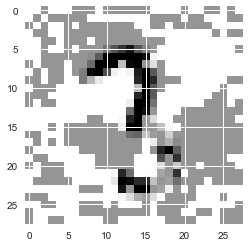

In [33]:
grads = {}

def save_grad(name):  #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
    def hook(grad):
        grads[name] = grad
    return hook

model.train(False)
criterion = torch.nn.CrossEntropyLoss()

x = Variable(img, requires_grad=True).cuda().double()
x.register_hook(save_grad('grad'))
h_adv = model.logits_forward(x) / 10
cost = criterion(h_adv, label.cuda().view(1))
cost.backward()

h = model(x)
h_logs = model.logits_forward(x) 

imge = (img.double() + grads['grad'].cpu().sign().double() *0.5)
logits = model.logits_forward(imge.cuda())
soft = model(imge.cuda())
imge = imge.cpu().numpy().reshape(28,28)
plt.imshow(imge ,cmap='Greys')


print('clean softmax = ', h.data, h.argmax().item(), h.max().item(), '\n')
print('clean logits = ', h_logs, h_logs.argmax().item(), h_logs.max().item(), '\n')
print('gradients =', 'none-zero' if grads['grad'].cpu().numpy().any() else 'Zero!!', '\n')
print('logits =', logits.data, logits.argmax().item(), logits.max().item(), '\n')
print('softmax =', soft.data, soft.argmax().item(), soft.max().item(), '\n')